# 원의 성질을 이용한 삼변측량 프로그램 구현
수학 시간에 원의 방정식이 GPS에서 쓰인다는 내용을 배우고 GPS의 핵심 원리인 삼변측량을 직접 파이썬으로 구현해보았다.

## 두 원의 교점 구하기

In [13]:
import math
from random import randint

import numpy as np
import matplotlib.pyplot as plt

PRECISION = 10  # 정확도 (반올림 자릿수)


class Circle:
    def __init__(self, x, y, radius):
        self.pos = np.array([x, y])
        self.radius = radius
    
    def visual_repr(self, **kwargs):
        return plt.Circle(self.pos, self.radius, ec='black', fc='#1f77b450', **kwargs)

    def intersect(self, circle2):
        """
        Referenced

        Intersection points of two circles using the construction of triangles
        as proposed by Paul Bourke, 1997.
        http://paulbourke.net/geometry/circlesphere/

        with gratitude by Jungroy
        """
        X1, Y1 = self.pos                     # 첫번째 원의 좌표
        X2, Y2 = circle2.pos                  # 두번째 원의 좌표
        R1, R2 = self.radius, circle2.radius  # 반지름

        Dx = X2-X1
        Dy = Y2-Y1
        D = round(math.sqrt(Dx**2 + Dy**2), PRECISION)  # 두 원의 중심 사이의 거리

        # 두 원이 만나지 않는 경우: 예외
        if D > R1 + R2:
            raise Exception("두 원은 만나지 않는다")
        elif D < math.fabs(R2 - R1):
            raise Exception("만나지 않음 - 한 원이 다른 원 속에 있다")
        elif D == 0 and R1 == R2:
            raise Exception("만나지 않음 - 두 원이 같다")

        # 두 원의 교점 개수
        if D == R1 + R2 or D == R1 - R2:
            CASE = "두 원이 한 점에서 만난다"
        else:
            CASE = "두 원이 두 점에서 만난다"
        
        chorddistance = (R1**2 - R2**2 + D**2)/(2*D)           # 만나는 점을 이은 현과 중심점 사이의 거리 (a)
        halfchordlength = math.sqrt(R1**2 - chorddistance**2)  # 현 길이의 절반 (h)
        chordmidpointx = X1 + (chorddistance*Dx)/D             # 현의 중점(P_2)의 좌표
        chordmidpointy = Y1 + (chorddistance*Dy)/D

        # 교점의 좌표
        I1 = (round(chordmidpointx + halfchordlength * math.cos(math.atan2(-Dx, Dy)), PRECISION),
                round(chordmidpointy + halfchordlength * math.sin(math.atan2(-Dx, Dy)), PRECISION))

        I2 = (round(chordmidpointx - halfchordlength * math.cos(math.atan2(-Dx, Dy)), PRECISION),
                round(chordmidpointy - halfchordlength * math.sin(math.atan2(-Dx, Dy)), PRECISION))

        # 원의 중심과 이루는 각의 크기 순서대로 정렬
        theta1 = round(math.degrees(math.atan2(I1[1]-Y1, I1[0]-X1)), PRECISION)
        theta2 = round(math.degrees(math.atan2(I2[1]-Y1, I2[0]-X1)), PRECISION)

        if theta2 > theta1:
            I1, I2 = I2, I1
        
        return (np.array((I1, I2)), CASE)

![](diagram1.png)

$$
\frac {{r_1}^2-{r_2}^2+d^2} {2d}
$$
$$
=\ \frac {a^2-b^2+d^2} {2d}
$$
$$
=\ \frac {(a+b)(a-b)+d^2} {2d}
$$
$$
=\ \frac {d^2+(a-b)d} {2d}
$$
$$
=\ \frac {a-b+d} {2}
$$
$$
=\ a
$$
위와 같은 방법으로 점A에서 두 교점을 지나는 현까지의 거리(a)를 구할 수 있다.


![](diagram2.png)

$$
\triangle AMH_M \sim \triangle ABH_B
$$
$$
a:x:y=d:dx:dy
$$
$$
\therefore x=dx \times \frac a d \ \ \ \ y=dy \times \frac a d
$$
삼각형의 닮음의 성질을 이용하여 두 교점의 중점의 좌표를 구했다.


![](diagram3.png)

$$
\theta = -\frac 1 {\arctan {\frac {dx} {dy}}}
$$
$$
p = h \times \sin \theta
$$
$$
q = h \times \sin \theta
$$
그림과 같이 중점을 지나는 선분AB의 수선을 긋고, 그 기울기를 이용하여 삼각함수로 p와 q의 길이를 구하면 두 교점의 중점에서 p, q를 더하거나 빼서 두 교점의 좌표를 알아낼 수 있다.

[2.82945408 0.99709056] [-1.74945408 -2.43709056]


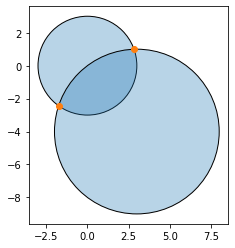

In [9]:
c1 = Circle(0, 0, 3)
c2 = Circle(3, -4, 5)

intersections = c1.intersect(c2)[0]

print(*intersections)

fig, ax = plt.subplots()
ax.set_aspect("equal")

ax.add_patch(c1.visual_repr())
ax.add_patch(c2.visual_repr())

plt.scatter(intersections[:,0], intersections[:,1], c='tab:orange')

plt.show()

위에서 만든 함수로 이 두 원의 교점을 구해 주황색 점으로 표시하게 했다. 도표를 보면 함수가 잘 작동하는 것을 확인할 수 있다.

## 삼변측량
삼변측량은 기준점의 위치와 기준점까지의 거리를 이용하여 한 점의 위치를 구하는 방법이다. 2차원 평면에서 위치를 유일하게 결정하기 위해서는 최소 3개의 기준점이 필요하다. 따라서 3개의 기준점과 거리를 받아 점의 위치를 구하는 함수를 만들기로 했다.

In [10]:
def almost_trilateration_with_three_circles(c1, c2, c3):
    i1 = c1.intersect(c2)[0]
    i2 = c2.intersect(c3)[0]
    i3 = c3.intersect(c1)[0]

    centers = np.array([c3.pos, c1.pos, c2.pos])  # 원의 중심점
    intersections = np.array([i1, i2, i3])        # 교점

    # 두 원의 교점과 나머지 한 원의 중심과의 거리
    # [[x.xxx x.xxx]   c1, c2 의 두 교점의 다른 원의 중심까지의 거리
    #  [x.xxx x.xxx]   c2, c3
    #  [x.xxx x.xxx]]  c3, c1
    dists = np.sqrt(np.sum((intersections - np.tile(centers, 2).reshape((3, 2, 2))) ** 2, axis=2))

    min_indices = np.argmin(dists, axis=1) # 두가지 원이 만나는 두 점 중 거리가 더 짧은 것 (중앙에 위치한 점)
    max_indices = np.argmax(dists, axis=1) # 두가지 원이 만나는 두 점 중 거리가 더 큰 것 (바깥에 위치한 점)

    approx_position = np.mean(intersections[np.arange(min_indices.shape[0]),min_indices], 0)  # 대략적 위치

    # 도표 그림
    fig, ax = plt.subplots()
    ax.set_aspect("equal")

    # 원
    ax.add_patch(c1.visual_repr())
    ax.add_patch(c2.visual_repr())
    ax.add_patch(c3.visual_repr())

    # 교점
    colors = ['tab:blue', 'tab:green', 'tab:orange']
    plt.scatter(intersections[np.arange(min_indices.shape[0]),min_indices,0],
                intersections[np.arange(min_indices.shape[0]),min_indices,1], c=colors, edgecolors='black')  # 중앙에 위차한 점
    plt.scatter(intersections[np.arange(max_indices.shape[0]),max_indices,0],
                intersections[np.arange(max_indices.shape[0]),max_indices,1], c=colors)                      # 바깥에 위차한 점
    plt.scatter(*approx_position, c='y', edgecolors='black')                                                 # 대략적 위치

    plt.show()

    return intersections, dists, min_indices, max_indices, approx_position

처음에는 세 원 중 두 원을 골라 구한 교점들 중 동일한 3개의 점을 찾는 방법으로 하려고 했지만, [부동소수점오차](https://docs.python.org/ko/3/tutorial/floatingpoint.html) 때문에 동일한 세 개의 점이라도 계산되는 좌표는 아주 미세하게 다를 수 있어서 방법을 바꾸어야 했다. 원 두 개를 골라 둘의 교점들 중에서 나머지 한 원의 중심과의 거리가 더 작은 교점을 찾는 방법으로 원 세 개가 겹치는 부분의 경계에 있는 세 점을 고르고, 그 대략적인 위치로 세 점의 무게중심을 구한다. 물론 원 세 개가 겹치는 부분의 무게중심을 구하는 것이 더 적절하지만, 아직 그럴 방법을 알아낼 수 없어서 대신 세 점의 무게중심을 구했다.

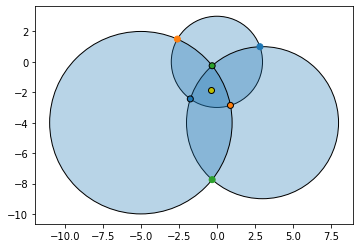

교점
[[[ 2.82945408  0.99709056]
  [-1.74945408 -2.43709056]]

 [[-0.3125     -0.25469043]
  [-0.3125     -7.74530957]]

 [[-2.59888232  1.4986029 ]
  [ 0.89156525 -2.86445656]]]

중심점까지의 거리
[[9.28823263 3.60676235]
 [0.40314199 7.75161122]
 [7.84742742 2.39477681]]

대략적 위치
[-0.39012961 -1.85207919]


In [11]:
c1 = Circle(0, 0, 3)
c2 = Circle(3, -4, 5)
c3 = Circle(-5, -4, 6)

intersections, dists, min_indices, max_indices, approx_position = almost_trilateration_with_three_circles(c1, c2, c3)
print(f"교점\n{intersections}\n\n중심점까지의 거리\n{dists}\n\n대략적 위치\n{approx_position}")

세 원이 한 점에서 모두 만나지 않을 때의 그림이다. 같은 원의 쌍의 교점은 같은 색으로 칠해져 있고, 세 원이 겹치는 부분의 경계 위에 있는 점들은 검정색 테두리가 있다. 결과로 나온 대략적 위치인 세 점의 무게중심은 노란색 점이다.

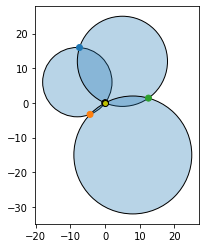

교점
[[[-7.37560976 15.9804878 ]
  [ 0.          0.        ]]

 [[12.51219512  1.3902439 ]
  [-0.          0.        ]]

 [[-4.33859397 -3.30559541]
  [-0.         -0.        ]]]

중심점까지의 거리
[[34.58612439 17.        ]
 [21.02379604 10.        ]
 [17.92960089 13.        ]]

대략적 위치
[0. 0.]


In [12]:
c1 = Circle(-8, 6, 10)
c2 = Circle(5, 12, 13)
c3 = Circle(8, -15, 17)

intersections, dists, mins, maxs, approx_position = almost_trilateration_with_three_circles(c1, c2, c3)
print(f"교점\n{intersections}\n\n중심점까지의 거리\n{dists}\n\n대략적 위치\n{approx_position}")

세 원이 한 점에서 만날 때의 그림이다.

## 느낀 점
학교에서는 원 두 개를 이용한 문제를 많이 봤는데, 이번에 여러 개의 원을 갖고 문제를 해결해보려고 하니 너무 많은 경우가 생겨서 복잡했다.
다음에는 3개 이상의 기준점을 이용하여 거리값에 오차가 있더라도 준수한 정확도를 낼 수 있는 함수를 만들거나 3차원 공간에서 삼변측량을 하는 방법도 알아보고 싶다. 3차원 공간에서 삼변측량을 할 수 있다면 소리를 이용하여 천둥같은 큰 소리가 난 위치를 알아낼 수 있을 것이다.